# Mitotic Proteomic Indicators 


checking to see if RB

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
#sys.path.append('C:\\Users\\brittany henderson\\GitHub\\GBM_for_CPTAC\\')
#import cis_functions as f

import cptac
import cptac.utils as u

In [2]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [3]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [4]:
def get_missense_truncation_comparison(cancer_object, reduced_omics_df):
    #get omics data and tumors
    tumors = reduced_omics_df.loc[reduced_omics_df['Sample_Status'] == 'Tumor'] #drop Normal samples


    somatic_mutations = cancer_object.get_somatic_mutation().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'Truncation', 
            'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
            'stopgain': 'Truncation', 'stoploss': 'Truncation', 'nonsynonymous SNV': 'Missense',
            'nonframeshift insertion': 'Missense','nonframeshift deletion': 'Missense', 
            'nonframeshift substitution': 'Missense'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'Missense', 'In_Frame_Ins': 'Missense',
            'Missense_Mutation': 'Missense', 'Frame_Shift_Del': 'Truncation','Nonsense_Mutation': 'Truncation', 
            'Splice_Site': 'Truncation', 'Frame_Shift_Ins': 'Truncation','Nonstop_Mutation':'Truncation'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Missense']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Truncation']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare missense with wildtype.')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = truncation_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare truncation with wildtype.')
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missense')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = missence_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics

    ### Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'Missense')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    return binary_mut_omics


In [5]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


#### Specify Mutation Gene, Create List of Proteins

In [6]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
mut_gene = 'RB1'
prots = ['CCNA1',"CDK6","CCNA2", "CCNE1", "P21", "CCND1", "MYC", "GMNN", "CCNB1","QDT1" ]

#### Compare proteomics of the listed proteins with RB1 Mutation

In [7]:
#Join RB1 Mutations to proteomic data for given proteins
prot_df = brain.join_omics_to_mutations(mutations_genes=mut_gene, omics_genes=prots, omics_df_name='proteomics')

#Keep only Tumor Samples
prot_df = prot_df.loc[prot_df['Sample_Status'] == 'Tumor']

#Create binary classification of Mutated/Wildtype
for ind, row in prot_df.iterrows():
    if row[mut_gene + '_Mutation_Status'] == 'Wildtype_Tumor':
        prot_df.loc[ind, mut_gene + '_Mutation_Binary'] = 'Wildtype'
    else:
        prot_df.loc[ind, mut_gene + '_Mutation_Binary'] = 'Mutated'
        
#Drop unneeded columns
prot_df = prot_df.drop([mut_gene+'_Mutation', mut_gene+'_Location', mut_gene+'_Mutation_Status','Sample_Status'], axis=1)
prot_df.head()

Name,CCNA1_proteomics,CDK6_proteomics,CCNA2_proteomics,CCNE1_proteomics,P21_proteomics,CCND1_proteomics,MYC_proteomics,GMNN_proteomics,CCNB1_proteomics,QDT1_proteomics,RB1_Mutation_Binary
Sample_ID,,,,,,,,,,,
S001,NaN,-0.961,0.0317,NaN,NaN,-0.0943,NaN,-0.154,-1.280,NaN,Mutated
S002,NaN,-0.949,-0.4750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mutated
S003,NaN,0.219,0.1600,NaN,NaN,-0.0993,NaN,0.173,-0.986,NaN,Wildtype
S004,NaN,-1.800,0.6660,NaN,NaN,-0.4220,NaN,NaN,-0.469,NaN,Mutated
S005,NaN,-0.921,-1.0500,NaN,NaN,0.5200,NaN,-0.479,-1.400,NaN,Wildtype


Determine significant comparisons when adjusting for multiple testing

In [8]:
comp_cols = list(prot_df.columns)
comp_cols.remove(mut_gene+'_Mutation_Binary')
results = u.wrap_ttest(df=prot_df, label_column=mut_gene+'_Mutation_Binary', comparison_columns=comp_cols, verbose=True)

CCNA1_proteomics :  nan
CDK6_proteomics :  1.3257661339450778e-05
CCNA2_proteomics :  0.15314315422319075
CCNE1_proteomics :  nan
P21_proteomics :  nan
CCND1_proteomics :  0.3479230401724581
MYC_proteomics :  nan
GMNN_proteomics :  0.46324574098635096
CCNB1_proteomics :  0.020694809513780287
QDT1_proteomics :  nan
1 significant comparisons!


#### Show results that were statistically significant

In [9]:
results

,Comparison,P_Value
0,CDK6_proteomics,0.000013


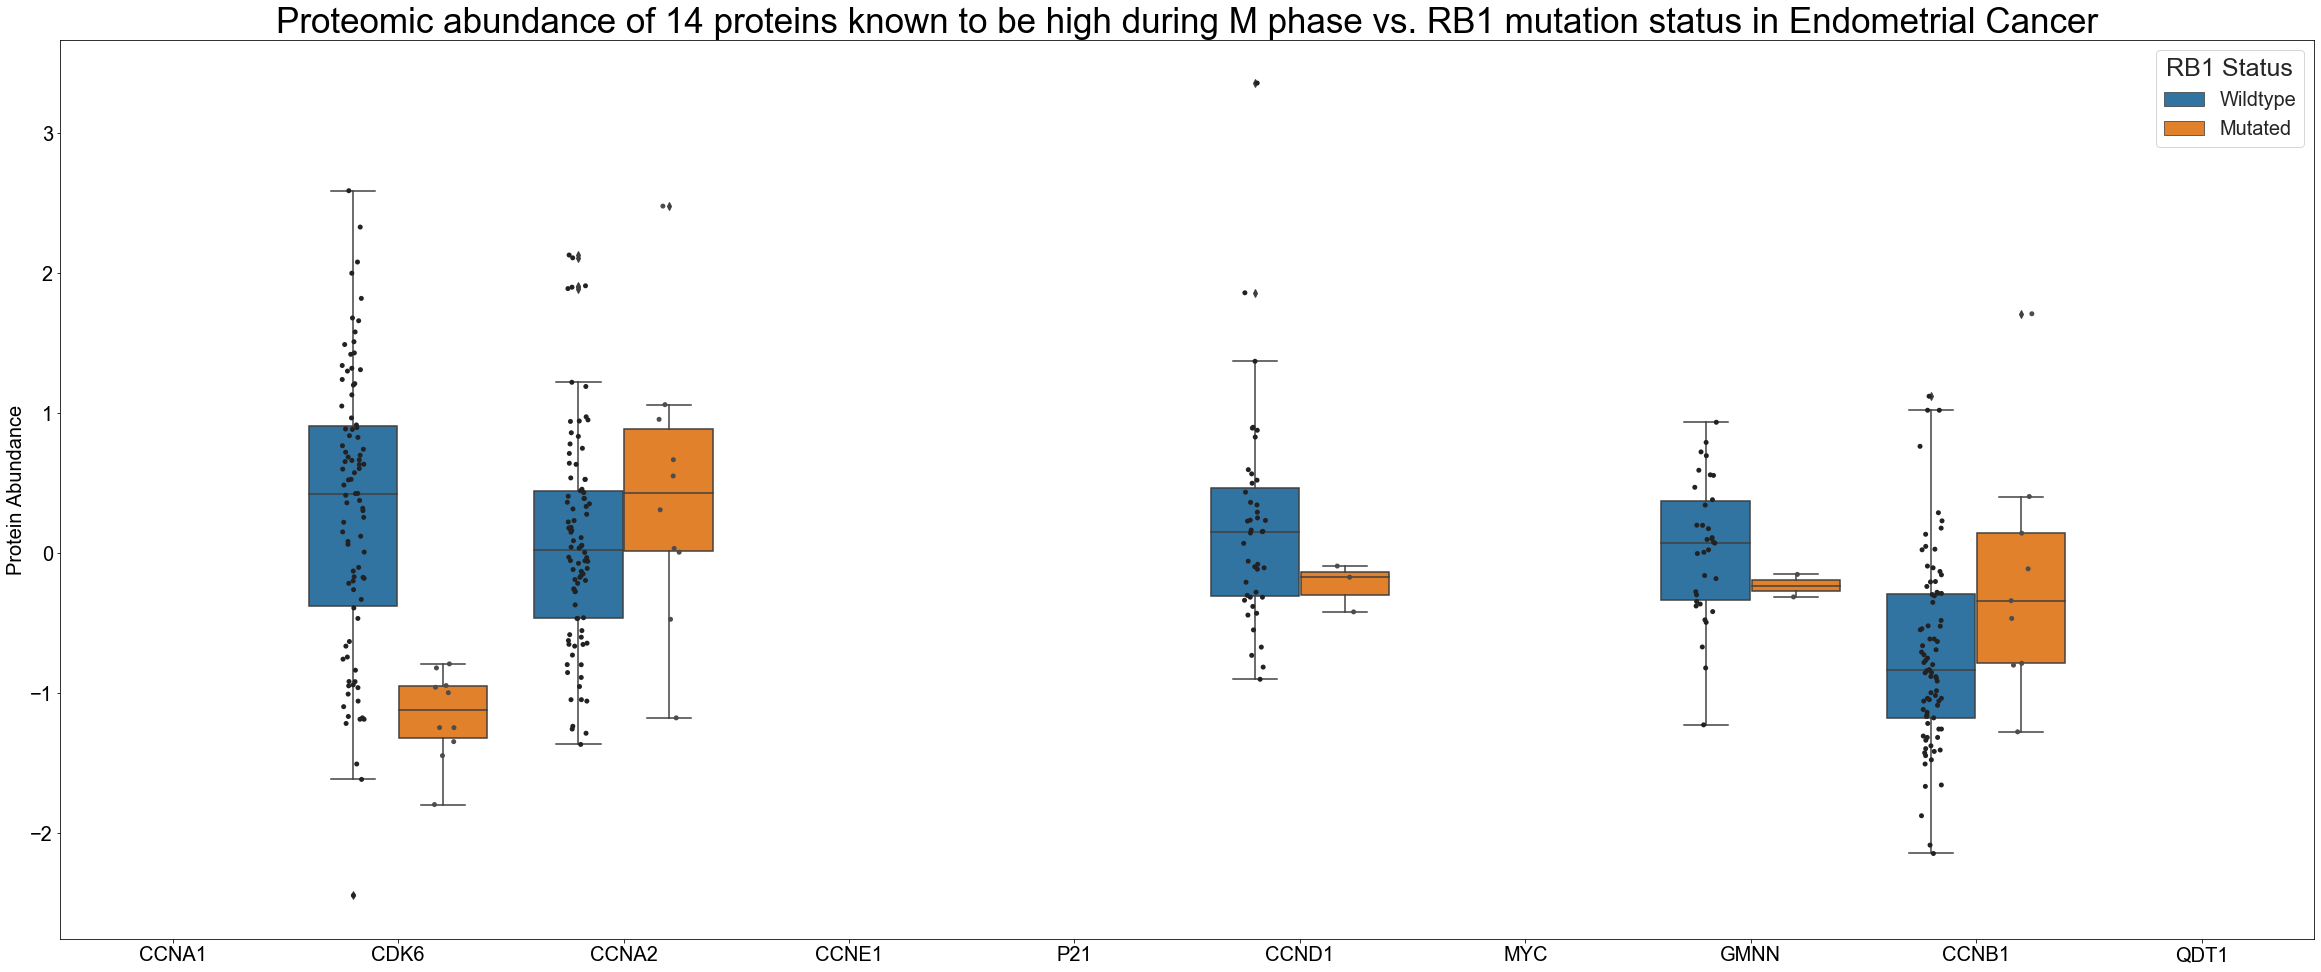

In [10]:
#Specify dimensions and settings
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
plotdf = pd.melt(prot_df, id_vars=['RB1_Mutation_Binary'], value_vars=comp_cols)
plotdf = plotdf.replace(to_replace=r'_proteomics', value='', regex=True)
my_pal = {"Wildtype": "blue", "Mutated": "orange"}

#Make boxplot
plot = sns.boxplot(data=plotdf, y='value', x='Name',hue='RB1_Mutation_Binary', hue_order=['Wildtype','Mutated']).set_title("Proteomics vs. TP53 Mutation",fontsize = '40')

#Overlay stripplot
plot = sns.stripplot(data=plotdf, y='value', x='Name',hue='RB1_Mutation_Binary', hue_order=['Wildtype','Mutated'], dodge=True, jitter=True, color='.3')

#Change Style and label sizes
plot.tick_params(labelsize=20)
plot.set_xlabel('')
plot.set_ylabel('Protein Abundance', fontsize='20')
plot.set_title('Proteomic abundance of 14 proteins known to be high during M phase vs. RB1 mutation status in Endometrial Cancer', fontsize = '35')
sns.set_style("white")

#Adjust the Legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2],['Wildtype','Mutated'], title='RB1 Status', fontsize='20', frameon=True)
plot.get_legend().get_title().set_fontsize('25')

CDK6 only significant difference
CCNB1 is close p = 0.02 CCNB1 inc a little bit G1-S, but more so S to G2 